In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from scipy.special import binom
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
import math
import scipy.stats as stats
import random
import itertools
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [16]:
def get_lagged_vars(df,iv,lags,freq = "D"):
    '''
    Desc:
    Create new columns in df. These columns are just shifts of the original columns, and referred as 
    lagged variables.
    
    Parameters:
    df: pandas dataframe
    iv: list of column names from df. These are the independent variables
    lags: list of non-negative integers
    freq: frequency of the dattimeindex of df. default is "D"
    
    Output:
    updates df with new lagged variable columns and list of lagged variabls
    '''
    iv_wLags = list(iv)
    for v in iv:
        for l in lags:
            new_name = v + "_lag" + str(l)
            df[new_name] = df[v].shift(l, freq = freq)
    df.drop
    return df,iv_wLags

def var_selection(iv,lags,num_var_model = None) :
    '''
    Desc: 
    For each int in num_var_model, create every combination of variables from iv AND 
    corresponding lags to consider
    
    Parameters:
    iv: list of non-lagged variables
    lags: list of non-negative integers
    num_var_model: list of positive integers that correspond to the number of variables 
    to consider when developing a model
    
    Output:
    list. first entry is the combinations of base variables. second entry is dictionary where 
    keys are integers and returns the number of lags to loop through
    '''
    if num_var_model == None:
        num_var_model = range(1,len(iv) + 1)
    base_mev = []
    lag_map = {}
    for value in num_var_model:
        base_mev = base_mev + list(itertools.combinations(iv, value))
        lag_map[value] = list(itertools.product(lags, repeat = value))
    return base_mev,lag_map
    
def get_columns(iv, num_var_model = None):
    '''
    Desc:
    Provides the statistics of each model we want to capture. 
    
    Inputs:
    iv: list of independent variables 
    num_var_model: list of integers, where an integer a in num_var_model indicates that we consider models with
        a-many independent variables. Default is ALL, ie, [1,2,3,...,len(iv)]
        
    Output:
    returns the list of column names used to construct the output of testing all models
    '''
    if num_var_model == None:
        num_var_model = range(1,len(iv) + 1)
    n = max(num_var_model)
    variables = []
    coeff = []
    pvals = []
    vifs = []
    for i in range(n):
        variables.append("Variable_{}".format(str(i)))
        coeff.append("Coefficient_{}".format(str(i)))
        pvals.append("PValue_{}".format(str(i)))
        vifs.append("VIF_{}".format(str(i)))
    others = ['AIC','BIC','Rsq','RMSE','AdjRsq','Significant_Variables','Multicolinearity',
              'Base_MEV_ID','Durbin_Watson','BreuschPagan','jarque_bera']
    output_cols = variables + coeff + ['Coefficient_const'] + pvals + ['PValue_const'] + vifs + others + iv
    return output_cols
    
def get_cnt_models(iv,lags,num_var_model = None):
    '''
    Desc:
    Determine the number of models (and thus the number of rows in the output of the main script) to compute
    
    Input: 
    iv: list of independent variables 
    lags: list of non-negative integers
    num_var_model: list of integers, where an integer a in num_var_model indicates that we consider models with
        a-many independent variables. Default is ALL, ie, [1,2,3,...,len(iv)]
        
    Output:
    Number of models to compute given variables, lags, and num_var_model as an integer
    '''
    if num_var_model == None:
        num_var_model = range(1,len(iv) + 1)
    for v in num_var_model:
        if v < 1 or v != int(v):
            return("Error num_var_model input: values of num_var_model must be positive integers: issue {}".format(v))
    
    number_of_lags = len(lags)
    number_of_variables = len(iv)
    count = 0
    for number_of_selected_variables in num_var_model:
        count += (number_of_lags ** number_of_selected_variables ) * binom(number_of_variables,number_of_selected_variables)
    return int(count) 

def main(df,dv,iv,lags,num_var_model = None):
    '''
    Desc:
    Computes OLS models that predict a column dv given columns iv and lags. Provides statistics to help determine
    the validitity, accuracy, and fit of each model
    
    Input:
    df: pandas dataframe. Has column dv and columsn iv in it
    dv: string. its a name of a column in df that represent the dependent variable
    iv: list of independent variables 
    lags: list of non-negative integers
    num_var_model: list of integers, where an integer a in num_var_model indicates that we consider models with
        a-many independent variables. Default is ALL, ie, [1,2,3,...,len(iv)]
        
    Output:
    Pandas datarfame that captures each OLS model constructed and corresponding statistics of the models
    '''
    
    # prep dataframe with lagged variables and get list of mevs with lags
    df,iv_wlags = get_lagged_vars(df,iv,lags)
    df = df.dropna()
    
    # get count of the number of models to consider
    total_models = get_cnt_models(iv,lags)
    
    # get combinations of base mevs and iterations of lags per number of variabls
    base_mev, lag_map = var_selection(iv,lags)
    
    # Get columns to record the statistics of the model
    output_cols = get_columns(iv)
    
    # prep output
    output = pd.DataFrame(columns = output_cols, index = range(total_models))
    
    #row index
    i = 0
    
    # go through all models
    for model_index,selected_base in enumerate(base_mev):
        current_count_var = len(selected_base)
        for lag_size in lag_map[current_count_var]:
            current_model_var = []
            for index, lag in enumerate(lag_size):
                current_model_var.append(selected_base[index] + "_lag" + str(lag))
                
            # Train model
            print("Total {} current {}".format(total_models,i), end = '\r')
            
            x = df[current_model_var]
            x = sm.add_constant(x, prepend = False)
            y = df[dv]
            model = sm.OLS(y,x)
            results = model.fit()
            
            # populate output
            output['Base_MEV_ID'][i] = model_index
            for mev in selected_base:
                output[mev][i] = True
                
            # a priori populate as Multicolinearity as Pass unless VIF calc is over 5
            output['Multicolinearity'][i] = 'Pass'
            
            for cnt, v in enumerate(results.params.index):
                if v != 'const':
                    output['Variable_' + str(cnt)][i] = v
                    output['Coefficient_' + str(cnt)][i] = results.params[v]
                    output['PValue_' + str(cnt)][i] = results.pvalues[v]
                    vif = variance_inflation_factor(results.model.exog, cnt)
                    output['VIF_' + str(cnt)][i] = vif
                    if vif > 5:
                        output['Multicolinearity'][i] = 'Fail'
                else:
                    output['Coefficient_const'][i] = results.params[v]
                    output['PValue_const'][i] = results.pvalues[v]

            output['AIC'][i] = results.aic
            output['BIC'][i] = results.bic
            output['Rsq'][i] = results.rsquared
            output['AdjRsq'][i] = results.rsquared_adj
            output['RMSE'][i] = math.sqrt(results.mse_resid)
            output['Significant_Variables'][i] = np.where(results.pvalues.max() < 0.05,
                                                         'Pass','Fail')
            output['Durbin_Watson'][i] = durbin_watson(results.resid)
            output['BreuschPagan'][i] = sms.het_breuschpagan(results.resid, results.model.exog)[1]
            output['jarque_bera'][i] = jarque_bera(results.resid)[1]
            i += 1
    return output


In [17]:
# Read data
df = pd.read_csv('fred_data.csv', index_col = 'date')

# fill in missing days - linear interpolation
idx = pd.date_range(df.index.min(), df.index.max())
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx).interpolate()

# Specify the independent variabls
iv = ['OVXCLS',
      'DCOILWTICO',
      'SP500',
      'T10YIE',
      'DBAA',
      'VIXCLS'
     ]

# Specifiy the lags
lags = [0,7,14]

# Specify the dependent variabl
dv = 'CBBTCUSD'

In [18]:
output = main(df,dv,iv,lags)

In [57]:
# filter for models that satisfy some properties
filtered = output[
    (output.Multicolinearity == 'Pass') &
    (output.Significant_Variables == 'Pass') &
    (output.jarque_bera < 0.05) & # goodness of fit, ~ normal 
    (output.BreuschPagan < 0.05) # heteroskedasticity 
]
# Use AdjRsq as statistic that represents top models
filtered.sort_values(['AdjRsq'], ascending = False, inplace = True)

# keep only the best combinations of lags (using AdjRsq) per each group of MEVs
top_candidates = filtered.drop_duplicates("Base_MEV_ID", keep = 'first').reset_index()

In [58]:
# Preview Candidates
top_candidates.head()

,index,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Coefficient_0,Coefficient_1,Coefficient_2,...,Base_MEV_ID,Durbin_Watson,BreuschPagan,jarque_bera,OVXCLS,DCOILWTICO,SP500,T10YIE,DBAA,VIXCLS
0,2207,OVXCLS_lag0,DCOILWTICO_lag14,SP500_lag0,T10YIE_lag0,VIXCLS_lag14,NaN,127.225601,-137.863804,17.544571,...,57,0.029834,0.0,0.0,True,True,True,True,NaN,True
1,711,OVXCLS_lag0,DCOILWTICO_lag14,SP500_lag0,T10YIE_lag0,NaN,NaN,106.155559,-117.719981,17.187649,...,41,0.026854,0.0,0.0,True,True,True,True,NaN,NaN
2,2638,OVXCLS_lag0,DCOILWTICO_lag0,T10YIE_lag0,DBAA_lag0,VIXCLS_lag7,NaN,218.6625,234.864968,30414.03726,...,59,0.056483,0.0,0.0,True,True,NaN,True,True,True
3,261,OVXCLS_lag0,SP500_lag0,T10YIE_lag0,NaN,NaN,NaN,113.670211,17.117558,15160.558228,...,25,0.024965,0.0,0.0,True,NaN,True,True,NaN,NaN
4,936,OVXCLS_lag0,DCOILWTICO_lag0,T10YIE_lag0,DBAA_lag0,NaN,NaN,275.807866,237.703135,30391.219408,...,44,0.070953,0.0,0.0,True,True,NaN,True,True,NaN


In [35]:
# get variable names
top_model_vars = top_candidates[['Variable_0','Variable_1','Variable_2','Variable_3','Variable_4','Variable_5']].iloc[0].dropna().values

# Retrain to get model
x = df[top_model_vars].dropna()
x = sm.add_constant(x,prepend = False)
y = df[['CBBTCUSD']][df.index.isin(x.index)]
res = sm.OLS(y,x).fit()

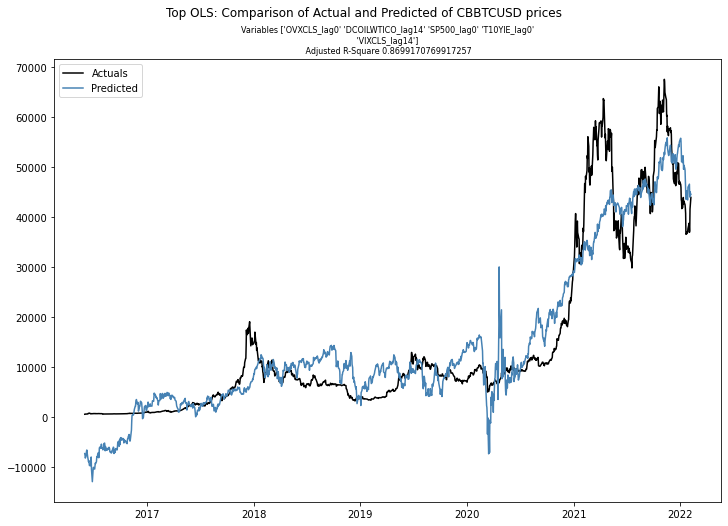

In [63]:
fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.suptitle('Top OLS: Comparison of Actual and Predicted of {} prices'.format(dv))
plt.title('Variables {} \n Adjusted R-Square {}'.format(top_model_vars,top_candidates.loc[0,'AdjRsq']),
          fontsize = 8
         )
plt.plot(y, color = 'black')
plt.plot(res.predict(x), color = 'steelblue')
plt.legend(["Actuals","Predicted"], loc = 'upper left')
plt.show()

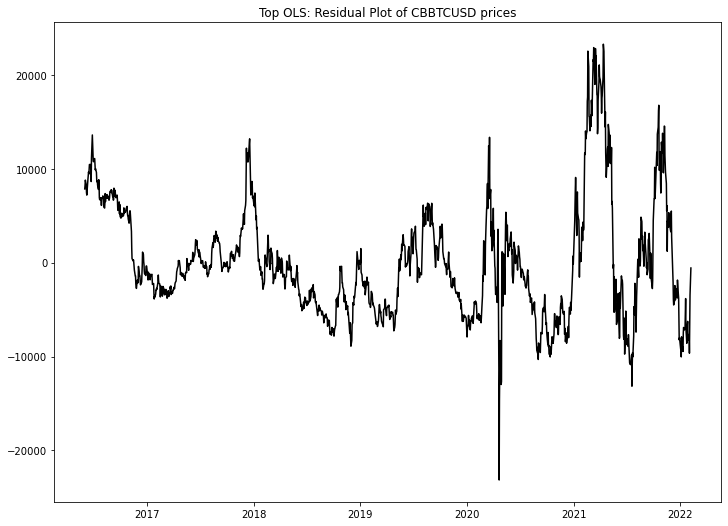

In [48]:
fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.title('Top OLS: Residual Plot of {} prices'.format(dv))
plt.plot(res.resid, color = 'black')
plt.show()

In [65]:
output.to_csv(r'Output/all_OLS_models.csv')